In [105]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## DATA UNDERSTANDING

In [106]:
df1 = pd.read_excel("PSP_Jan_Feb_2019.xlsx")
print("Number of rows and Columns: ", df1.shape)
df1.head()

Number of rows and Columns:  (50410, 8)


,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [107]:
for col in ['country','success', 'PSP', '3D_secured', 'card']:
   print(col,":", df1[col].unique()," - ", df1[col].nunique())

country : ['Germany' 'Austria' 'Switzerland']  -  3
success : [0 1]  -  2
PSP : ['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']  -  4
3D_secured : [0 1]  -  2
card : ['Visa' 'Diners' 'Master']  -  3


In [108]:
#Ignoring column 'Unnamed: 0' as it is merely the serial number of the records and is of no use
df1.drop(["Unnamed: 0"], axis=1, inplace=True)
print(df1.columns)
display(df1.head())

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card'], dtype='object')


,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [109]:
#Loading the PSP transaction fees data as a dataFrame
df2 = pd.DataFrame({"PSP":["Moneycard","Goldcard","UK_Card","Simplecard"], 
                    "success_txnFee":[5,10,3,1],
                    "failure_txnFee":[2,5,1,0.5]
                   })
display(df2.head())

,PSP,success_txnFee,failure_txnFee
0,Moneycard,5,2.0
1,Goldcard,10,5.0
2,UK_Card,3,1.0
3,Simplecard,1,0.5


In [110]:
df1.describe()

,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [111]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


In [112]:
df1.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

## DATA PREPARATION

In [113]:
print("Total record count: ",df1.shape[0])
print("Duplicate count: ",df1[df1.duplicated()].shape[0])

#Removing the duplicate records from the dataset
df1.drop_duplicates(inplace=True) 
print("Record count after removing duplicates: ", df1.shape[0])

Total record count:  50410
Duplicate count:  81
Record count after removing duplicates:  50329


In [114]:
#Merging both the dataframes into a single dataframe based on the PSP 
df3 = pd.merge(df1,df2, on = "PSP")
df3.sample(5)

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee
19734,2019-02-12 14:58:47,Germany,327,0,UK_Card,0,Master,3,1.0
10498,2019-01-23 10:44:22,Switzerland,114,0,UK_Card,0,Master,3,1.0
37265,2019-02-20 21:52:05,Germany,246,0,Simplecard,0,Diners,1,0.5
25403,2019-02-26 17:29:35,Germany,95,1,UK_Card,1,Diners,3,1.0
38280,2019-02-26 09:01:23,Austria,318,0,Simplecard,0,Visa,1,0.5


In [115]:
df3["tmsp"] = pd.to_datetime(df3["tmsp"])

#Sorting the dataframe by the timestamp in ascending order
df3.sort_values(["tmsp"], inplace=True) 

#Finding the difference between consecutive timestamps 
df3["tmsp_diff"] = df3["tmsp"] - df3["tmsp"].shift(1) 
df3.reset_index(inplace=True)
df3.drop(["index"], axis=1, inplace=True)

#Converting the timedelta (difference) into seconds
df3["tmsp_diff"]  = df3["tmsp_diff"].apply(lambda x: x.total_seconds())

#Assigning a value 1 if the transaction is done within a minute after the previous transaction, or 0 otherwise
df3["withinMinute"] =  df3["tmsp_diff"].apply(lambda x: 1 if x<=60 else 0)

#Introducing a feature ‘noOfAttempts’ which captures the number of transaction attempts based on the given criteria and assigning an initial value of 1 for all records
df3["noOfAttempts"] = 1

#Incrementing the 'noOfAttempts' consequently if withinMinute = 1
for i, r in df3.iterrows():
     if i< df3.shape[0]-1:
          if (df3["country"][i] == df3["country"][i+1]) & (df3["amount"][i] == df3["amount"][i+1]) & (df3["withinMinute"][i+1]<=60):
            df3["noOfAttempts"][i+1] = df3["noOfAttempts"][i] + 1
df3.tail()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,tmsp_diff,withinMinute,noOfAttempts
50324,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,3,1.0,123.0,0,1
50325,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,3,1.0,69.0,0,1
50326,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,3,1.0,16.0,1,2
50327,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,3,1.0,32.0,1,3
50328,2019-02-28 23:48:19,Austria,91,1,Moneycard,0,Master,5,2.0,43.0,1,4


In [116]:
#Creating a new column called Month
df3['Month'] = df3['tmsp'].dt.month 

#Creating a new column called Day
df3['Day'] = df3['tmsp'].dt.day     

#Creating a new column called Hour
df3['Hour'] = df3['tmsp'].dt.hour 

#Creating a new column called Weekday with sunday as 6 and monday as 0
df3["Weekday"] = df3['tmsp'].dt.dayofweek
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df3['Weekday'] = df3['Weekday'].map(day_mapping)

df3.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,tmsp_diff,withinMinute,noOfAttempts,Month,Day,Hour,Weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,3,1.0,NaN,0,1,1,1,0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,3,1.0,6.0,1,2,1,1,0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,3,1.0,92.0,0,1,1,1,0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,3,1.0,24.0,1,2,1,1,0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,80.0,0,1,1,1,0,Tuesday


In [117]:
import copy
df3["tmsp_diff"] = df3["tmsp_diff"].fillna(0)
df3.drop(['tmsp_diff', 'withinMinute'], axis=1, inplace=True)

#LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
df4 = copy.deepcopy(df3)
categorical_cols = ["country","PSP", "card","Weekday"]
label_encoder = LabelEncoder()
for col in categorical_cols:
        df4[col] = label_encoder.fit_transform(df4[col])
        print(col,":", label_encoder.classes_)
df4.sample(5)

country : ['Austria' 'Germany' 'Switzerland']
PSP : ['Goldcard' 'Moneycard' 'Simplecard' 'UK_Card']
card : ['Diners' 'Master' 'Visa']
Weekday : ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


,tmsp,country,amount,success,PSP,3D_secured,card,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,Weekday
16075,2019-01-18 15:33:00,0,213,0,3,1,1,3,1.0,4,1,18,15,0
40012,2019-02-15 17:34:38,1,178,0,3,0,2,3,1.0,1,2,15,17,0
16819,2019-01-19 15:38:05,1,117,0,1,0,1,5,2.0,3,1,19,15,2
727,2019-01-01 13:48:30,2,215,0,2,0,1,1,0.5,6,1,1,13,5
13715,2019-01-15 17:18:16,1,206,0,2,0,2,1,0.5,1,1,15,17,5


In [118]:
#ONE-HOT ENCODING     
df5 = copy.deepcopy(df3)

#Using drop_first=True to drop the redundant column

#df5.drop(["Weekday"], axis=1 ,inplace=True)
categorical_cols = ["country", "PSP","card", "Weekday"]
df5 = pd.get_dummies(df5, columns=categorical_cols, drop_first=True)

#Display the resulting DataFrame
print(df5.shape)
df5.head()

(50329, 23)


,tmsp,amount,success,3D_secured,success_txnFee,failure_txnFee,noOfAttempts,Month,Day,Hour,...,PSP_Simplecard,PSP_UK_Card,card_Master,card_Visa,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,2019-01-01 00:01:11,89,0,0,3,1.0,1,1,1,0,...,0,1,0,1,0,0,0,0,1,0
1,2019-01-01 00:01:17,89,1,0,3,1.0,2,1,1,0,...,0,1,0,1,0,0,0,0,1,0
2,2019-01-01 00:02:49,238,0,1,3,1.0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
3,2019-01-01 00:03:13,238,1,1,3,1.0,2,1,1,0,...,0,1,0,0,0,0,0,0,1,0
4,2019-01-01 00:04:33,124,0,0,1,0.5,1,1,1,0,...,1,0,0,0,0,0,0,0,1,0


## DATA VISUALISATION(EDA)

In [120]:
first_attempt_df = df3[df3["noOfAttempts"]==1][["success"]].value_counts().reset_index(name = "TransactionCount")

display(first_attempt_df)

fig = px.bar(first_attempt_df, x='success', y='TransactionCount', text='TransactionCount',
             labels={'success': 'Transaction Status', 'TransactionCount': 'Transaction Count'},
             title='Transaction Status of first payment attempt by user')

fig.update_traces(texttemplate='%{text}', textposition='outside')

#Update x-axis tick labels using dictionary
labels = {0: 'Failed', 1: 'Successful'}
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext = [labels[0], labels[1]]
    ),
    title={
        'x': 0.5  #Center title
    }
)
fig.show()

,success,TransactionCount
0,0,21639
1,1,5653


In [121]:
#Grouping the data records based on country and success columns to get the total count of failed and successful transactions in each country

countrywise_success_txns = df3.groupby(["country","success"])[["tmsp"]].count().reset_index()
countrywise_success_txns.rename(columns={"tmsp":"TransactionCount"}, inplace=True)
countrywise_success_txns["success"] = countrywise_success_txns['success'].astype(str)
display(countrywise_success_txns)

#Using Plotly bar chart to visualize
color_map = {'0': 'red', '1': 'green'}
fig = px.bar(countrywise_success_txns, x='country', y='TransactionCount',
             text='TransactionCount',
             barmode='group',
             color='success',
             color_discrete_map = color_map,
             labels={'country': 'country', 'TransactionCount': 'Transaction Count'},
             title='Success and Failure Transactions in each country')
fig.update_layout(xaxis_type='category')
fig.show()

,country,success,TransactionCount
0,Austria,0,7808
1,Austria,1,2013
2,Germany,0,24096
3,Germany,1,6088
4,Switzerland,0,8197
5,Switzerland,1,2127


In [122]:
#Calculating Avg success rates
df3["psp_success_rate"]=df3.groupby(['PSP'])[['success']].transform('mean')
df3["card_success_rate"]=df3.groupby(['card'])[['success']].transform('mean')
df3["country_success_rate"]=df3.groupby(['country'])[['success']].transform('mean')


#Creating tables for PSPs, cards, countries and their success rates
rates = df3[["PSP","card","country","psp_success_rate","card_success_rate","country_success_rate"]]
psp_success_rate_df = rates.groupby(["PSP"])[["psp_success_rate"]].mean().reset_index()
card_success_rate_df = rates.groupby(["card"])[["card_success_rate"]].mean().reset_index()
country_success_rate_df = rates.groupby(["country"])[["country_success_rate"]].mean().reset_index()

display(psp_success_rate_df)
display(card_success_rate_df)
display(country_success_rate_df)


#Plotting the success rates
trace_A = go.Bar(x=psp_success_rate_df['PSP'], y=psp_success_rate_df['psp_success_rate'], name='Txn Success Rate by PSPs', marker_color='blue', text=psp_success_rate_df["psp_success_rate"])
trace_B = go.Bar(x=card_success_rate_df['card'], y=card_success_rate_df['card_success_rate'], name='Txn Success Rate by Cards', marker_color='green', text=card_success_rate_df["card_success_rate"])
trace_C = go.Bar(x=country_success_rate_df['country'], y=country_success_rate_df['country_success_rate'], name='Txn Success Rate by Country', marker_color='orange', text=country_success_rate_df["country_success_rate"])

#Creating subplots
fig = plotly.subplots.make_subplots(rows=1, cols=3, subplot_titles=("Success Rate by PSPs", "Success Rate by Cards","Success Rate by Country"))

fig.add_trace(trace_A, row=1, col=1)
fig.add_trace(trace_B, row=1, col=2)
fig.add_trace(trace_C, row=1, col=3)

fig.update_layout(showlegend=False)
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()

,PSP,psp_success_rate
0,Goldcard,0.406172
1,Moneycard,0.218833
2,Simplecard,0.158212
3,UK_Card,0.194861


,card,card_success_rate
0,Diners,0.223247
1,Master,0.194252
2,Visa,0.208756


,country,country_success_rate
0,Austria,0.204969
1,Germany,0.201696
2,Switzerland,0.206025


In [123]:
#Country wise PSP Success Rate  :
success_rate_by_psp = df3.groupby(['PSP','country'])['success'].mean().reset_index()
fig = px.bar(success_rate_by_psp, x='PSP', y='success', text='success', barmode='group', labels={'success': 'Success Rate'}, color='country')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.update_layout(title='Country-wise PSP Success Rates', xaxis_title='PSP', yaxis_title='Success Rate')
fig.show()

In [124]:
card_PSP = df3.groupby(["card","PSP"])[["success_txnFee","failure_txnFee"]].sum().reset_index()
card_PSP

fee_summary = card_PSP.melt(id_vars=['card', 'PSP'], value_vars=['success_txnFee', 'failure_txnFee'],
                      var_name='Transaction Type', value_name='Total Fee')
display(fee_summary.sample(5))

#Plotting grouped bar chart for total success and failure transaction fees by PSP grouped by Card
fig = px.bar(fee_summary, x='card', y='Total Fee', color='Transaction Type', facet_col='PSP', barmode='group',
             labels={'Total Fee': 'Total Fee', 'card': 'Card', 'PSP': 'PSP'},
             title='Total Success and Failure Transaction Fees by PSP grouped by Card')

fig.show()

,card,PSP,Transaction Type,Total Fee
8,Visa,Goldcard,success_txnFee,7750.0
14,Diners,Simplecard,failure_txnFee,1178.0
22,Visa,Simplecard,failure_txnFee,1421.0
4,Master,Goldcard,success_txnFee,17630.0
11,Visa,UK_Card,success_txnFee,18432.0


In [125]:
#Calculating total success and failure transaction fees collected by each PSP
success_fee = df3.loc[df3['success']==1].groupby('PSP')['success_txnFee'].sum().reset_index()
failure_fee = df3.loc[df3['success']==0].groupby('PSP')['failure_txnFee'].sum().reset_index()

#Merging the two sums for success and failure into a single DataFrame
fee_summary = pd.merge(success_fee, failure_fee, on='PSP', how='outer').fillna(0)
fee_summary.columns = ['PSP', 'Success Fee', 'Failure Fee']
fee_summary["total_txn_fee"] = fee_summary["Success Fee"] +fee_summary["Failure Fee"]
display(fee_summary.sort_values(["Failure Fee"], ascending=False))

#Comparing the total fee collection by each PSP
fig = px.bar(fee_summary, x='PSP', y=['total_txn_fee'],
             barmode='group', labels={'value': 'Total Fees', 'PSP': 'PSP'},
             title='Total Transaction Fee collection by PSP')
fig.update_traces(marker_color='blue')
fig.show()

,PSP,Success Fee,Failure Fee,total_txn_fee
3,UK_Card,15426,21246.0,36672.0
1,Moneycard,9075,12958.0,22033.0
0,Goldcard,13030,9525.0,22555.0
2,Simplecard,1968,5235.5,7203.5


In [126]:
#Processing data to get transaction counts by PSP
psp_transactions = df3["PSP"].value_counts().reset_index()
psp_transactions.rename(columns={"index":"PSP", "PSP":"TransactionCount"}, inplace=True)

#Plotting bar graph to visualize total transactions via each PSP 
fig = px.bar(psp_transactions, x='PSP', y='TransactionCount',
             title='Total Transactions via each PSP', 
             text='TransactionCount',  
             labels={'TransactionCount': 'Transaction Count'})

fig.update_traces(marker_color='orange',texttemplate='%{text}', textposition='outside')
fig.show()

In [127]:
#Plotting grouped bar chart for total success and failure transaction fees by PSP
fig = px.bar(fee_summary, x='PSP', y=['Success Fee', 'Failure Fee'],
             barmode='group', labels={'value': 'Total Fees', 'PSP': 'PSP'},
             title='Total Success and Failure Transaction Fee collection by PSP')

fig.show()

In [128]:
#Filtering successful transactions
successful_transactions = df3[df3['success'] == 1]

#Grouping successful transactions by hour and counting occurrences
success_by_hour = successful_transactions.groupby(['Hour',"PSP"]).size().reset_index(name='count')

#Plotting the trend of successful transactions over each hour of a day
fig = px.line(success_by_hour, x='Hour', y='count', color='PSP', 
              labels={'count': 'Successful Transaction Count', 'Hour': 'Hour of the day', 'PSP': 'PSP'},
              title='Trend of Successful Transactions by PSPs Over Each Hour')

fig.show()

In [129]:
#Grouping successful transactions by weekday and counting occurrences
success_df = successful_transactions.groupby(['Weekday',"PSP"]).size().reset_index(name='count')
fig = px.line(success_df, x='Weekday', y='count', color='PSP', 
              labels={'count': 'Successful Transaction Count', 'Weekday': 'Day of the Week', 'PSP': 'PSP'},
              title='Trend of Successful Transactions by PSPs Over Each weekday')
fig.show()

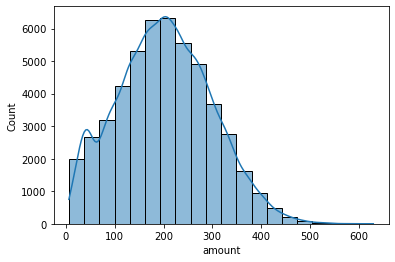

In [130]:
#Plotting histogram for transaction amounts
sns.histplot(df3, x='amount', bins=20, kde=True)
plt.show()

In [131]:
#Grouping by 'number of attempts' and calculating the mean success rate
success_rate = df3.groupby('noOfAttempts')['success'].mean().reset_index()

#Plotting the success rate vs. number of attempts using Plotly
fig = px.bar(success_rate, x='noOfAttempts', y='success', 
             labels={'success': 'Avg Success Rate', 'noOfAttempts': 'Number of Attempts'}, 
             title='Success Rate vs. Number of Attempts')

fig.update_layout(xaxis_type='category')

fig.show()

In [132]:
#Set 'tmsp' as the DataFrame index
timedf = df3.set_index('tmsp')

#Resample data daily and calculate the daily success rate
daily_success_rate = timedf['success'].resample('D').mean().reset_index()

#Then, create the plot using Plotly
fig = px.line(daily_success_rate, x='tmsp', y='success', title='Daily Transaction Success Rate')
fig.update_layout(xaxis_title='Date', yaxis_title='Success Rate')
fig.show()

In [133]:
card_provider_distribution = df3['card'].value_counts().reset_index()
fig = px.bar(card_provider_distribution, x='index', y='card', text='card')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(title='Credit Card Provider Distribution', xaxis_title='Card Provider', yaxis_title='Frequency')
fig.show()

In [134]:
fig = px.bar(df1['3D_secured'].value_counts().reset_index(), x='index', y='3D_secured', text='3D_secured')
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(title='3D Secure vs. Non-3D Secure Transactions', xaxis_title='3D Secured', yaxis_title='Count')
fig.show()

In [135]:
fig = px.violin(df1, y='amount', x='success', box=True, points="all",
                labels={'amount': 'Transaction Amount', 'success': 'Transaction Result'},
                title='Distribution of Transaction Amounts by Success/Failure')

fig.show()

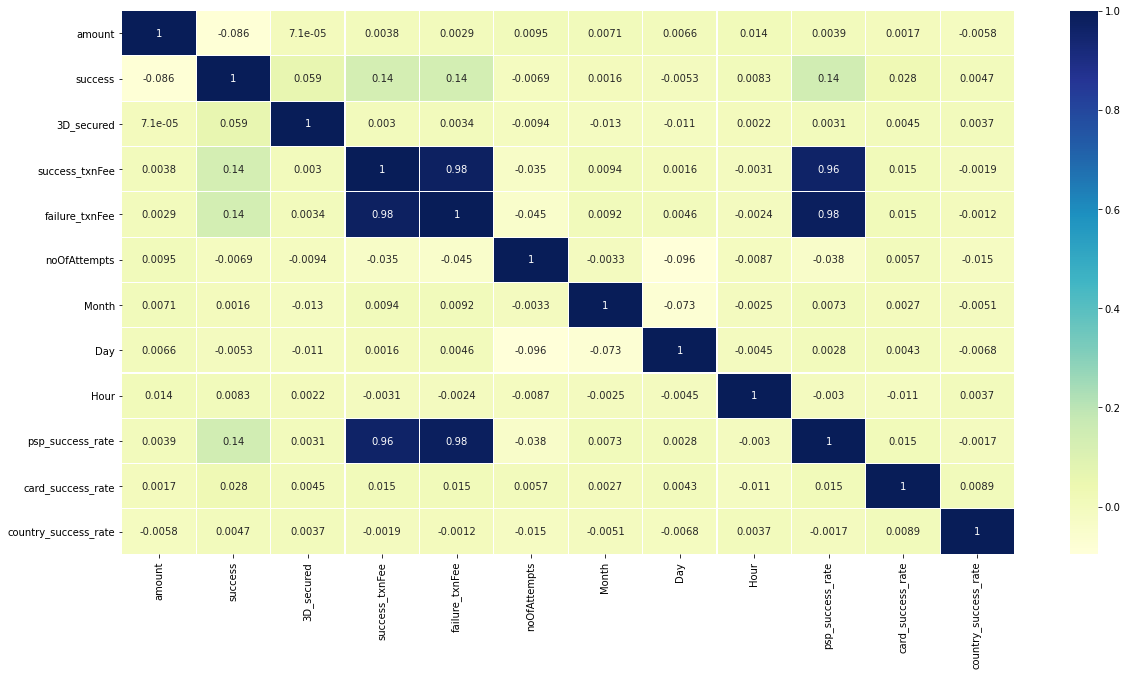

In [136]:
plt.figure(figsize=(20,10))
sns.heatmap(df3.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.show()

## MODELLING AND EVALUATIONS

In [137]:
X = df4.drop(["tmsp","success",'Month'],axis=1)
y = df4['success']

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model initialization
model = LogisticRegression(solver='liblinear')

# Define hyperparameters for grid search
param_grid = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model on the training set
y_train_pred = best_model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')
cm_train = confusion_matrix(y_train, y_train_pred)

# Evaluate the best model on the testing set
y_test_pred = best_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix for training set
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)

# Print evaluation metrics and confusion matrix for testing set
print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

Training set:
Accuracy: 0.7990462707696893
Precision: 0.7612915985912726
Recall: 0.7990462707696893
F1 Score: 0.7159929791969142
Confusion Matrix:
[[32008   106]
 [ 7985   164]]
Testing set:
Accuracy: 0.7923703556526922
Precision: 0.7180703086366587
Recall: 0.7923703556526922
F1 Score: 0.7070048532142381
Confusion Matrix:
[[7946   41]
 [2049   30]]


In [140]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create an XGBoost classifier
clf = xgb.XGBClassifier()

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Predict the target variable for the training and testing sets
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

# Compute evaluation metrics for the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_score_train = f1_score(y_train, y_train_pred, average='weighted')

# Compute evaluation metrics for the testing set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')

# Compute confusion matrix for the training and testing sets
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics and confusion matrix
print("Training set:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1 Score:", f1_score_train)
print("Confusion Matrix:")
print(cm_train)
print("")

print("Testing set:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_score_test)
print("Confusion Matrix:")
print(cm_test)

Training set:
Accuracy: 0.8309365919082036
Precision: 0.8359493604691866
Recall: 0.8309365919082036
F1 Score: 0.7853106319713846
Confusion Matrix:
[[31857   257]
 [ 6550  1599]]

Testing set:
Accuracy: 0.7891913371746473
Precision: 0.7291424078234271
Recall: 0.7891913371746473
F1 Score: 0.7272316782815759
Confusion Matrix:
[[7770  217]
 [1905  174]]
